In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os.path
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from scipy.linalg import sqrtm
import qiskit.quantum_info as qi
from qiskit.providers.aer import extensions  # import aer snapshot instructions
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit.aqua.operators import StateFn
from qiskit.aqua.operators import Z
%matplotlib inline
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.providers.aer.extensions

We will use the hamiltonian

$H =  \frac{1}{2}\left(J_{1}\sigma_{z}^{(1)}+J_{2} \sigma_{z}^{(2)}\right) +\frac{J_{12}}{4}\left(\sigma_{z}^{(1)}\otimes \sigma_{z}^{(2)} - \sigma_{z}^{(1)} -\sigma_{z}^{(2)} \right) + \frac{1}{2}\left( Bz1 \sigma_{x}^{(1)} + Bz2\sigma_{x}^{(2)}\right)$

The Trotter-suzuki aprroximation, if $t$ is large, Trotter-Suzuki formulas can still be used to simulate the dynamics accurately by breaking it up into a sequence of short time-steps. Let $r$ be the number of steps taken in the time evolution, so each time step  runs for time $t/r$. Then, we have that

$e^{-i H t} = e^{-i \sum_{j}^{m} H_{j} t} = \left(\Pi_{j=1}^{m} e^{-iH_{j}t/r}  \right)^{r}+O(m^{2}t^{2}/r)$

which implies that if $r$ scales as $m^{2}t^{2}/\epsilon$ then the error can be made at most $\epsilon$ for any $\epsilon >0$. For ours Hamiltonian we can rewrite as 

$H =  \left(J_{1}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(1)}}{2} + \left(J_{2}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(2)}}{2} + \frac{J_{12}}{4}\sigma_{z}^{(1)}\otimes \sigma_{z}^{(2)}+\frac{1}{2}Bz1 \sigma_{x}^{(1)} + \frac{1}{2}Bz2\sigma_{x}^{(2)}$

this allow us to write te evolution of fisrt ordem

$e^{-i H t} = \left(e^{-i \left(J_{1}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(1)}}{2} t/r}e^{-i\left(J_{2}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(2)}}{2}t/r}e^{-i \frac{J_{12}}{4}\sigma_{z}^{(1)}\otimes \sigma_{z}^{(2)} t/r} e^{-i \frac{1}{2}Bz1 \sigma_{x}^{(1)} t/r}  e^{-i \frac{1}{2}Bz2\sigma_{x}^{(2)} t/r} \right)^{r}+O(5^{2}t^{2}/r)$

rewrite in terms of logic gates

$e^{-i H t} = \left(R_{z}^{1}\left(\left(J_{1}-\frac{J_{12}}{2}\right)\frac{t}{r} \right) R_{z}^{2}\left(\left(J_{2}-\frac{J_{12}}{2}\right)\frac{t}{r} \right) R_{zz}^{12}\left( \frac{J_{12}t}{2r}\right) R_{x}^{1}\left(Bz1 t/r\right)R_{x}^{2}\left(Bz2t/r\right) \right)^{r}  + O(5^{2}t^{2}/r)$

More accurate approximations can be built by constructing a sequence of operator exponentials such that the error terms cancel. The simplest such formula, the second order Trotter-Suzuki formula, takes the form

$e^{-i H t} = \left(\prod_{j=1}^{m} e^{-iH_{j}t/2r} \prod_{j=m}^{1} e^{-iH_{j}t/2r} \right)^{r} + O(m^{3}t^{3}/r^{2})$,

the error of which can be made less than $\epsilon$ for any $\epsilon >0$ by choosing $r$ to scale as $m^{3/2}t^{3/2}/\sqrt{\epsilon}$. For ours Hamiltonian

$e^{-i H t} = \left(e^{-i \left(J_{1}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(1)}}{2} t/2r}e^{-i\left(J_{2}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(2)}}{2}t/2r}e^{-i \frac{J_{12}}{4}\sigma_{z}^{(1)}\otimes \sigma_{z}^{(2)} t/2r} e^{-i \frac{1}{2}Bz1 \sigma_{x}^{(1)} t/2r}  e^{-i \frac{1}{2}Bz2\sigma_{x}^{(2)} t/2r} 
e^{-i \frac{1}{2}Bz2\sigma_{x}^{(2)} t/2r} e^{-i \frac{1}{2}Bz1 \sigma_{x}^{(1)} t/2r} e^{-i \frac{J_{12}}{4}\sigma_{z}^{(1)}\otimes \sigma_{z}^{(2)} t/2r} e^{-i\left(J_{2}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(2)}}{2}t/2r} e^{-i \left(J_{1}-\frac{J_{12}}{2}\right)\frac{\sigma_{z}^{(1)}}{2} t/2r} \right)+ O(5^{3}t^{3}/r^{2})
$
in terms of the logic gates

$e^{-i H t} = \left(R_{z}^{1}\left(\left(J_{1}-\frac{J_{12}}{2}\right)\frac{t}{2r} \right) R_{z}^{2}\left(\left(J_{2}-\frac{J_{12}}{2}\right)\frac{t}{2r} \right) R_{zz}^{12}\left( \frac{J_{12}t}{4r}\right) R_{x}^{1}\left(Bz1 t/2r\right)R_{x}^{2}\left(Bz2t/2r\right)R_{x}^{2}\left(Bz2t/2r\right) R_{x}^{1}\left(Bz1 t/2r\right)R_{zz}^{12}\left( \frac{J_{12}t}{4r}\right) R_{z}^{2}\left(\left(J_{2}-\frac{J_{12}}{2}\right)\frac{t}{2r} \right) R_{z}^{1}\left(\left(J_{1}-\frac{J_{12}}{2}\right)\frac{t}{2r} \right)\right)^{r} + O(5^{3}t^{3}/r^{2})$,




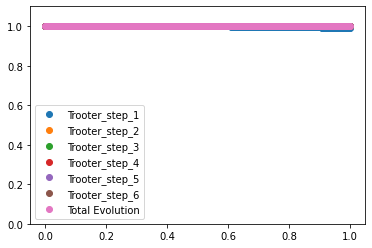

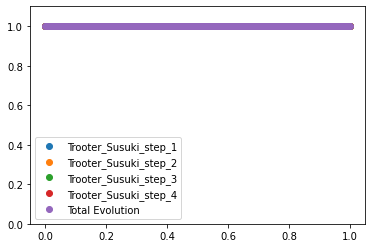

In [4]:
times= np.linspace(0,1,500)#definindo tempo de evolução
psi01 = ((np.sqrt(0.5))*qt.basis(2,1)+(np.sqrt(0.5))*qt.basis(2,0))
psi02 =  ((np.sqrt(0.5))*qt.basis(2,1)+(np.sqrt(0.5))*qt.basis(2,0))
rho0 = qt.tensor(psi01 * psi01.dag(),  psi02 * psi02.dag())

J1 = 280*2*np.pi/1000;
J2 = 320*2*np.pi/1000;
Bz1 = (1000*np.pi/16)/1000;
Bz2 = Bz1;
J12 = np.pi/140;

def H(J1,J2,J12,Bz1,Bz2):
        H = ((1/2) * (J1 * qt.tensor(qt.sigmaz(),qt.identity(2)) 
                      + J2 * qt.tensor(qt.identity(2),qt.sigmaz()))
    +(J12/4)*(qt.tensor(qt.sigmaz(),qt.sigmaz())-qt.tensor(qt.sigmaz(),qt.identity(2))
              -qt.tensor(qt.identity(2),qt.sigmaz()))
             +(1/2)*(Bz1*qt.tensor(qt.sigmax(),qt.identity(2)) 
                     + Bz2 * qt.tensor(qt.identity(2),qt.sigmax())))
        return H

def rho_evolution(J1,J2,J12,Bz1,Bz2, t):
    rhoev = (-1.0j * t * H(J1,J2,J12,Bz1,Bz2)).expm() * rho0 * (1.0j * t *H(J1,J2,J12,Bz1,Bz2)).expm()
    return rhoev    
def rhotrotten(J1,J2,J12,Bz1,Bz2,t, r):
    U = ((-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(2*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(2*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(2*r)).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(2*r))).expm())
    rhoev = (U**(r)) * rho0 *(U.dag()**(r)) 
    return rhoev
def rhoTrotter_Suzuki(J1,J2,J12,Bz1,Bz2, t, r):
    U2 = ((-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(8*r)).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(4*r))).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(4*r))).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(8*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(4*r)).expm()
         )
    
    rohev = (U2**r) * rho0 * (U2.dag()**r)
    return rohev

fide_ts4 = []
fide_Ori =[]
for t in times:
        Fide_ev_t = ((((rho_evolution(J1,J2,J12,Bz1,Bz2,t)).sqrtm() * rho_evolution(J1,J2,J12,Bz1,Bz2,t) * (rho_evolution(J1,J2,J12,Bz1,Bz2,t)).sqrtm()).sqrtm()).tr())**2
        fide_Ori.append(Fide_ev_t.real)
        
for r in [1,2,3,4,5,6]:
    fide_trotter = []
    for t in times:
        Fide_ev_lie = (((((rho_evolution(J1,J2,J12,Bz1,Bz2,t))).sqrtm() * rhotrotten(J1,J2,J12,Bz1,Bz2,t, r) * (rho_evolution(J1,J2,J12,Bz1,Bz2,t)).sqrtm()).sqrtm()).tr())**2
        fide_trotter.append(Fide_ev_lie.real)
    plt.plot(times,fide_trotter,'o', label = 'Trooter_step_'+str(r))
plt.plot(times,fide_Ori ,'o', label = 'Total Evolution')
plt.ylim(0,1.1)
plt.legend()

plt.show()

for r in [1,2,3,4]:
    fide_ts = []
    for t in times:
        Fide_ts = ((((rho_evolution(J1,J2,J12,Bz1,Bz2,t)).sqrtm() * rhoTrotter_Suzuki(J1,J2,J12,Bz1,Bz2,t,r) * (rho_evolution(J1,J2,J12,Bz1,Bz2,t)).sqrtm()).sqrtm()).tr())**2
        fide_ts.append(Fide_ts.real)
    plt.plot(times, fide_ts,'o', label = 'Trooter_Susuki_step_'+str(r))
plt.plot(times,fide_Ori ,'o', label = 'Total Evolution')
plt.ylim(0,1.1)
plt.legend()
plt.show()  

In [145]:
r = 2
U = ((-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(2*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(2*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(2*r)).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(2*r))).expm())
print((U * U) * rho0 *(U.dag() * U.dag()) )
print(U**2 * rho0 * U.dag()**2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.10829552+0.j          0.21263077-0.03575357j -0.01719768-0.09956079j
  -0.06626522-0.18835671j]
 [ 0.21263077+0.03575357j  0.42928979+0.j         -0.00089663-0.20115852j
  -0.06792154-0.39170271j]
 [-0.01719768+0.09956079j -0.00089663+0.20115852j  0.09426162+0.j
   0.18368766-0.03100885j]
 [-0.06626522+0.18835671j -0.06792154+0.39170271j  0.18368766+0.03100885j
   0.36815306+0.j        ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.10829552+0.j          0.21263077-0.03575357j -0.01719768-0.09956079j
  -0.06626522-0.18835671j]
 [ 0.21263077+0.03575357j  0.42928979+0.j         -0.00089663-0.20115852j
  -0.06792154-0.39170271j]
 [-0.01719768+0.09956079j -0.00089663+0.20115852j  0.09426162+0.j
   0.18368766-0.03100885j]
 [-0.06626522+0.18835671j -0.06792154+0.39170271j  0.18368766+0.03100885j
   0.36815306+0.j        ]]


In [138]:
J1 = 280*2*np.pi/1000;
J2 = 320*2*np.pi/1000;
Bz1 = (1000*np.pi/16)/1000;
Bz2 = bz1;
J12 = np.pi/140;
t=0.1
r=15
U2 = ((-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(8*r)).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(4*r))).expm()
         *(-1.0j * Bz2 * qt.tensor(qt.identity(2),qt.sigmax() *t/(4*r))).expm()
         *(-1.0j * Bz1 * qt.tensor(qt.sigmax(),qt.identity(2)) *t/(4*r)).expm()
         *(-1.0j * J12 * qt.tensor(qt.sigmaz(), qt.sigmaz()) *t/(8*r)).expm()
         *(-1.0j  * (J2 -(J12/2)) * qt.tensor(qt.identity(2),qt.sigmaz()) *t/(4*r)).expm()
         *(-1.0j  * (J1 -(J12/2)) * qt.tensor(qt.sigmaz(),qt.identity(2)) *t/(4*r)).expm()
         )
    
print((U2**r)* rho0 *(U2**r).dag())


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.2510701 +0.j         0.25042235-0.00154809j 0.24681577-0.04359858j
  0.24592073-0.04499201j]
 [0.25042235+0.00154809j 0.24978583+0.j         0.24644784-0.04196424j
  0.2455637 -0.0433596j ]
 [0.24681577+0.04359858j 0.24644784+0.04196424j 0.25020448+0.j
  0.24956658-0.00152525j]
 [0.24592073+0.04499201j 0.2455637 +0.0433596j  0.24956658+0.00152525j
  0.2489396 +0.j        ]]


In [134]:
rho_evolution(J1,J2,J12,Bz1,Bz2, 0.1)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25118106+0.j         0.25042025-0.00181523j 0.24692388-0.04361962j
  0.24587315-0.04525328j]
 [0.25042025+0.00181523j 0.24967487+0.j         0.2464912 -0.04170304j
  0.24545546-0.04333934j]
 [0.24692388+0.04361962j 0.2464912 +0.04170304j 0.25031375+0.j
  0.24956453-0.00178843j]
 [0.24587315+0.04525328j 0.24545546+0.04333934j 0.24956453+0.00178843j
  0.24883032+0.j        ]]

In [32]:
rhotrotten(a,b,c,d, e, 0.1, 2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25014841+0.00000000e+00j 0.24995438-1.29540433e-04j
  0.24995438-1.29540433e-04j 0.25023941-6.08432956e-05j]
 [0.24995438+1.29540433e-04j 0.24976057+0.00000000e+00j
  0.24976057+0.00000000e+00j 0.25004534+6.87914545e-05j]
 [0.24995438+1.29540433e-04j 0.24976057+0.00000000e+00j
  0.24976057+0.00000000e+00j 0.25004534+6.87914545e-05j]
 [0.25023941+6.08432956e-05j 0.25004534-6.87914545e-05j
  0.25004534-6.87914545e-05j 0.25033045+0.00000000e+00j]]